In [1]:
%matplotlib inline
import glob, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import lstsq
from astropy.io import fits
from scipy import interpolate
import multiprocessing
import statsmodels.api as sm
from scipy.special import eval_legendre, eval_chebys
from numpy.linalg import inv
from scipy.optimize import curve_fit
from scipy.interpolate import spline
from scipy import interpolate
from scipy import optimize
from lmfit import models, Parameters, Parameter, Model
from scipy.interpolate import interp1d
from lmfit.models import LorentzianModel, ConstantModel, LinearModel, PolynomialModel

In [2]:
from matplotlib.font_manager import FontProperties
font = FontProperties()
font.set_family('serif')
font.set_size('small')

In [3]:
DATA_DIR = '/Volumes/PFagrelius_Backup/sky_data/sky_flux/'
#DATA_DIR = '/Users/parkerf/Desktop/sample_spframe_files/'

In [4]:
spframe_files = glob.glob(DATA_DIR+'*_calibrated_sky.npy')

In [5]:
MetaData = np.load('/Users/parkerf/Research/SkyModel/BOSS_Sky/Analysis/MetaData/good_meta_rich.npy')

### Get Data to Look at 

In [6]:
def get_spectrum(color):
    available_plates = [int(filen[-23:-19]) for filen in spframe_files]
    if color == 'blue':
        Meta_Data = MetaData[(MetaData['CAMERAS'] == b'b1') | (MetaData['CAMERAS'] == b'b2')]
    elif color == 'red':
        Meta_Data = MetaData[(MetaData['CAMERAS'] == b'r1') | (MetaData['CAMERAS'] == b'r2')]
    plate = np.random.choice(available_plates,1)[0]
    
    print("plate: ",plate)
    ThisData = np.random.choice(Meta_Data[Meta_Data['PLATE'] == plate],1)[0]
    specno = ThisData['SPECNO']

    data = np.load(DATA_DIR+'/%s_calibrated_sky.npy' % str(plate))
    spectrum = data[specno]
    return spectrum

In [ ]:
#Mean Spectra
MEAN_DIR = '/Users/parkerf/Desktop/test_data/mean_flux/'
mean_files = glob.glob(MEAN_DIR+'*_mean_sky.npy')

In [ ]:
def get_mean_spectrum():
    wave_range = np.linspace(365,1040,(1040-365)*100)
    mean_file = np.random.choice(mean_files, 1)[0]
    mean_spectrum = np.load(mean_file)
    return wave_range, mean_spectrum

### Airglow Lines

In [7]:
AIRGLOW_DIR = '/Users/parkerf/Research/SkyModel/SkyModelling/AirglowSpectra/cosby'
AirglowFiles = glob.glob(AIRGLOW_DIR+'/*.txt')
AirglowLines = []
for file in AirglowFiles:
    data = pd.read_csv(file,delim_whitespace=True)
    d = data.to_records(index=False)
    AirglowLines.append(np.array(d))
AirglowLines = np.hstack(AirglowLines)

In [8]:
def air_to_vac(wave):
    """Index of refraction to go from wavelength in air to wavelength in vacuum
    Equation from (Edlen 1966)
    vac_wave = n*air_wave
    """
    #Convert to um
    wave_um = wave*.001
    ohm2 = (1./wave_um)**(2)

    #Calculate index at every wavelength
    nn = []
    for x in ohm2:
        n = 1+10**(-8)*(8342.13 + (2406030/float(130.-x)) + (15997/float(389-x)))
        nn.append(n)
    
    #Get new wavelength by multiplying by index of refraction
    vac_wave = nn*wave
    return vac_wave

In [9]:
#Get Vac Lines
b_sig = np.where(AirglowLines['obs_eint'] > 5)
bVL = air_to_vac(AirglowLines['obs_wave'])
bVL = bVL[b_sig] #nm to A
Hg = air_to_vac(np.asarray([404.6,435.8,546.0],dtype=float))

#print(Hg)
bVL = np.hstack([bVL, Hg])
BlueVacLines = bVL[bVL < 650]
#print(BlueVacLines)
print('blue: ',len(BlueVacLines))

blue:  38


In [10]:
r_sig = np.where(AirglowLines['obs_eint'] > 1)
rVL = air_to_vac(AirglowLines['obs_wave'])
rVL = rVL[r_sig] #nm to A
RedVacLines = rVL[rVL > 560]
RedVacLines = np.sort(RedVacLines)
RV1 = np.unique(np.round(RedVacLines, 0))
len(RV1)

229

In [11]:
r_sig = np.where((AirglowLines['obs_eint'] <= 3) & (AirglowLines['obs_eint'] > 1))
rVL = air_to_vac(AirglowLines['obs_wave'])
rVL = rVL[r_sig] #nm to A
RedVacLines = rVL[rVL > 560]
RedVacLines = np.sort(RedVacLines)
RV2 = np.unique(np.round(RedVacLines, 1))
len(RV2)

471

In [ ]:
BlueVacLines= np.load('/Users/parkerf/Research/SkyModel/BOSS_Sky/FitTest/files/blue_airglowlines.npy')

## Line Fit

In [12]:
def clean_spectra(spectrum, wave_range):
    """Takes out all nan/inf so lstsq will run smoothly
    """
    ok = ((np.isfinite(spectrum['SKY'])) & (spectrum['SKY'] > 0.))
    
    sky = spectrum['SKY'][ok]
    sigma = spectrum['IVAR'][ok]
    disp = spectrum['DISP'][ok]
    
    wave = wave_range[ok]
    return [wave,sky,sigma,disp]

In [13]:
def error_model(flux):
    sig_sq = flux + (0.01*flux)**2.
    ww = 1/np.sqrt(sig_sq)
    ww[ww>1e5] = 1/9
    
    return ww

In [14]:
def window_segment(spectrum, wave_range, line, window_size):
    wave, flux, ivar, sigma = clean_spectra(spectrum, wave_range)
    
    start, stop = [line-window_size, line+window_size]
    section = np.where((wave>start)&(wave<stop))
    window_flux= flux[section]
    window_flux[window_flux<0] = 1e-18
    window_wave = wave[section]
    
    window_weights = error_model(window_flux)
    
    return window_flux, window_wave, window_weights

In [15]:
def scatter_profile(x,amplitude, center, N_eff):
    w = center/N_eff * (1/(np.sqrt(2)*np.pi))
    top = w**2.
    bot = ((x-center)**2+w**2)
    l = amplitude*top/bot 
    return l

In [16]:
def gauss_profile(x, center, sigma, amplitude):
    return amplitude/(sigma*np.sqrt(2*np.pi))*np.exp(-(x-center)**2./(2*sigma**2))

In [40]:
def my_profile(x, amp1,amp2, a, center, wave1, wave2, sig1, sig2, N):
    gauss1 = amp1*np.exp(-(x-wave1)**2/(2*sig1**2.))
    gauss2 = amp2*np.exp(-(x-wave2)**2/(2*sig2**2.)) 
    core = gauss1 +gauss2
    
    scatt = scatter_profile(x, a, center, N)
    
    return core + scatt

In [41]:
def make_model(i, line):
    pref = 'f%s_' % str(i).zfill(4)
    model = Model(my_profile, prefix = pref)
    model.set_param_hint(pref+'amp1', value = 10, min = 0)
    model.set_param_hint(pref+'amp2', value = 10, min = 0)
    model.set_param_hint(pref+'center', value = line, min = line-.1, max = line + .1,vary = True)
    model.set_param_hint(pref+'delta1', value = .06, min = 0, max = 0.1, vary=True)
    model.set_param_hint(pref+'delta2', value = .09, min = 0, max = 0.1, vary=True)
    model.set_param_hint(pref+'wave1', expr = pref+'center + '+pref+'delta1')
    model.set_param_hint(pref+'wave2', expr = pref+'center - '+pref+'delta2')
    
    model.set_param_hint(pref+'a', value = 10, min = 0)
    model.set_param_hint(pref+'sig1', value = .1, min = 0,max = 1)
    model.set_param_hint(pref+'sig2', value = .1, min = 0, max = 1)
    model.set_param_hint(pref+'N', value = 83200, min = 0)
    

    return model

In [20]:
BV = np.array([391.44,  404.71,  435.92,  546.15,   557.89, 
        589.15,   589.75, 630.2])

In [167]:
blue_spectrum = get_spectrum('blue')
blue_wave, blue_flux, blue_ivar, blue_sigma = clean_spectra(blue_spectrum, blue_spectrum['WAVE'])
blue_ww = error_model(blue_flux)

plate:  4486


In [168]:
mod = None
for i, line in enumerate(BV):
    this_mod = make_model(i, line)
    if mod is None:
        mod = this_mod
    else:
        mod = mod + this_mod

offset = ConstantModel()
offset.set_param_hint('c', value = 1)
#offset.set_param_hint('m', value = 1)
b_mod = mod + offset
b_params = b_mod.make_params()

In [169]:
b_out = b_mod.fit(blue_flux, b_params, x= blue_wave, weights = blue_ivar,method = 'leastsq', fit_kws={'maxfev':  2000})

In [23]:
b_out.redchi

3.1332417092398517

In [ ]:
init = b_mod.eval(b_params, x=blue_wave)

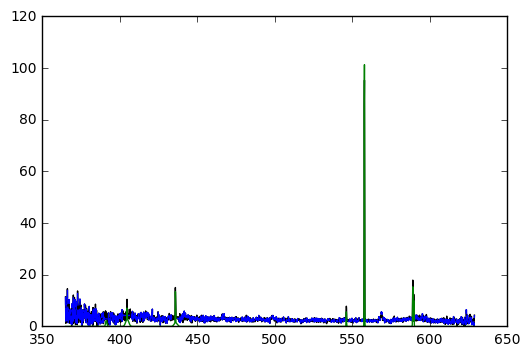

In [173]:
comps = b_out.eval_components(x=blue_wave)
plt.plot(blue_wave, blue_flux, 'k-',label = 'data')
#plt.plot(blue_wave, b_out.best_fit, label = 'fit')
# for name, comp in comps.items():
#     if name == 'constant':
#         pass
#     else: 
#         plt.semilogy(blue_wave, comps[name], label = name)
# #plt.semilogy(wave, init, label = 'init')
Cont = blue_flux.copy()
Lines = []
for name, comp in comps.items():
    
    if name == 'constant':
        pass
    else:
        idx = np.where(comp >10**-1)[0]
        Cont[idx] = 0
        Lines.append(comp)

Lines = np.sum(Lines, axis=0)

#plt.plot(blue_wave, Cont, 'r-',label = 'cont')
idx = np.where(Cont<=0)
#Cont[idx] = b_out.params['c'].value

groups = np.split(idx[0], np.where(np.diff(idx[0]) != 1)[0]+1)

for group in groups:
    first = group[0]
    last = group[-1]
    
    try:
        #print(blue_flux[first], blue_flux[last])
        mean_sky = np.mean([Cont[first-10:first-2], Cont[last+2:last+10]])
        Cont[first-2:last+2] = mean_sky
    except:
        mean_sky = np.mean(Cont[first-10:first-2])
        Cont[group] = mean_sky
plt.plot(blue_wave, Cont, 'b--',label = 'cont')
    
        
#print((idx[1:]-idx[:-1])==1)
#Cont[np.where(Cont < 0)] = b_out.params['c'].value 
#Lines = blue_flux - Cont
plt.plot(blue_wave, Lines, 'g-')
#plt.plot(blue_wave, Lines, 'b-',label = 'lines')
#plt.legend()
#plt.xlim(400,420)
#plt.xlim(550,560)
#plt.xlim(550,600)
#plt.xlim(540,550)
#plt.xlim(540,560)
#plt.xlim(400,450)
#plt.ylim(0,25)
#plt.ylim(pow(10,-1),pow(10,1))

In [26]:
for comp in comps.keys():
    if comp is not 'constant':
        print(np.round(b_out.params[comp+"center"].value,3))

391.466
404.774
436.0
546.151
557.89
589.179
589.784
630.231


2430


(1.0, 10000.0)

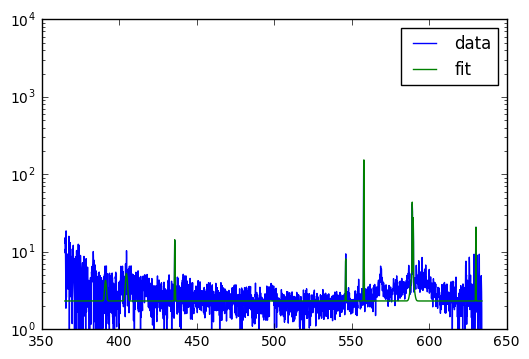

In [37]:
print(len(blue_wave))
plt.semilogy(blue_wave, blue_flux, label = 'data')
plt.semilogy(blue_wave, b_out.best_fit, label = 'fit')
#plt.semilogy(blue_wave, init, label = 'init')
#plt.plot(blue_wave, init, label = 'init')
plt.legend()
#plt.ylim(0,15)
#plt.xlim(550,600)
#plt.ylim(140,160)
plt.ylim(1e0,1e4)

(360, 630)

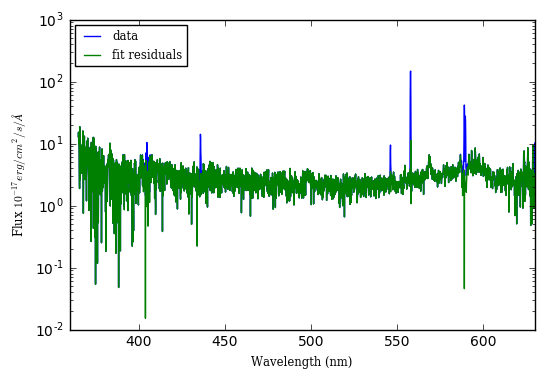

In [29]:
plt.semilogy(blue_wave, blue_flux, label = 'data')
plt.semilogy(blue_wave, Cont, label = 'fit residuals')

plt.legend(loc = 'upper left', prop = font)
plt.xlabel("Wavelength (nm)", fontproperties = font)
plt.ylabel("Flux $10^{-17} erg/cm^{2}/s/\AA$", fontproperties = font)
plt.xlim(360,630)
#plt.xlim(500,600)
#plt.ylim(0,15)

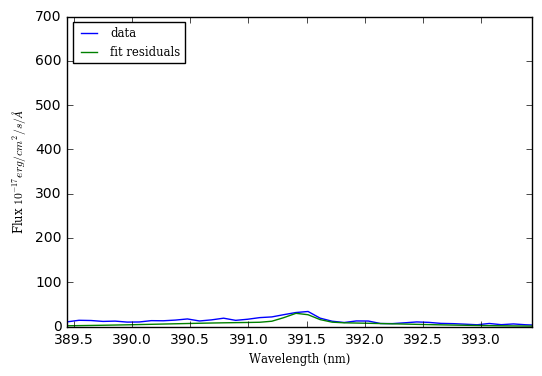

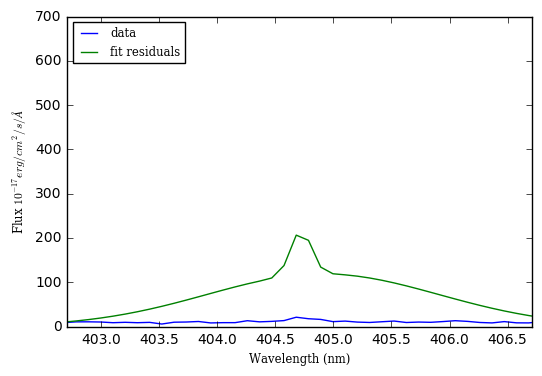

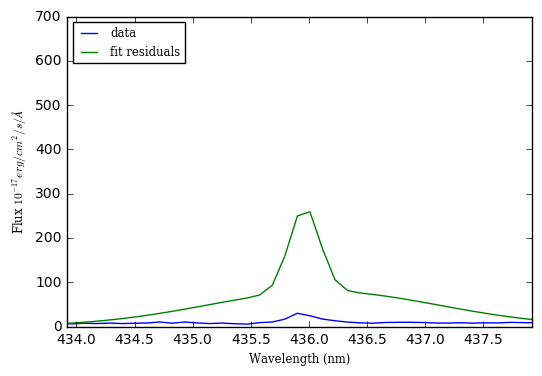

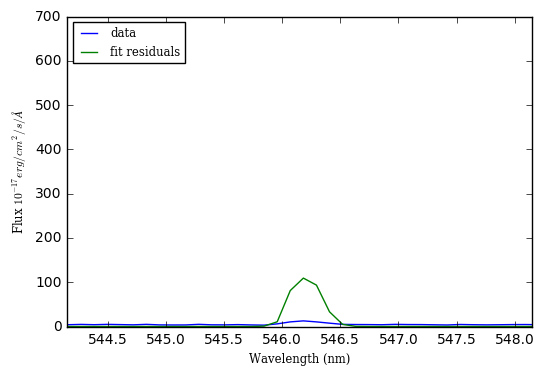

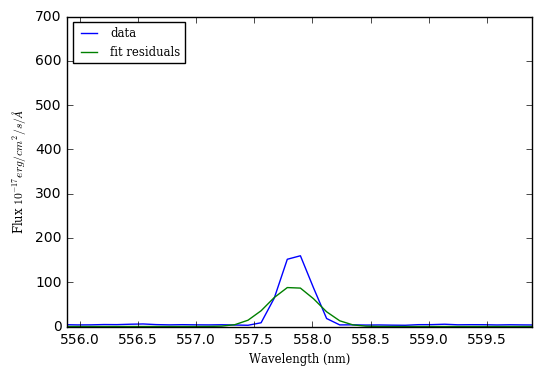

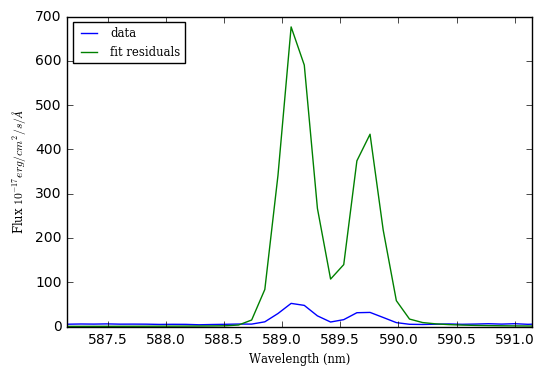

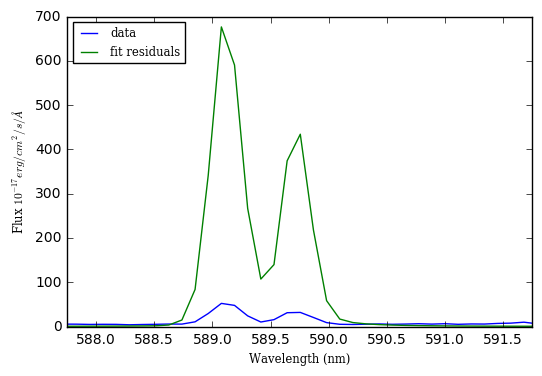

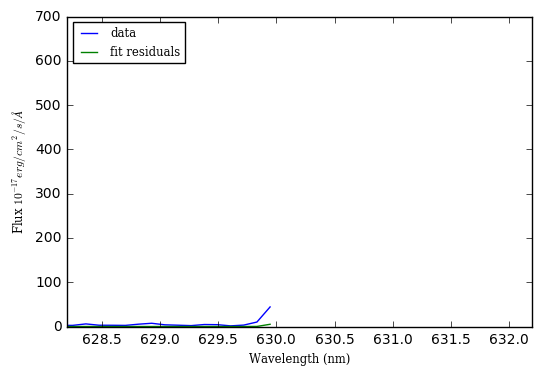

In [133]:
for line in BV:
    plt.figure()
    plt.plot(blue_wave, blue_flux, label = 'data')
    plt.plot(blue_wave, Lines, label = 'fit residuals')
    plt.legend(loc = 'upper left', prop = font)
    plt.xlabel("Wavelength (nm)", fontproperties = font)
    plt.ylabel("Flux $10^{-17} erg/cm^{2}/s/\AA$", fontproperties = font)
    #plt.xlim(360,630)
    plt.xlim(line-2, line+2)
    #plt.ylim(0,10)
    #plt.ylim(pow(10,0),pow(10,4))

In [ ]:
plt.semilogy(blue_wave, b_F, label = 'fit residuals')

In [ ]:
plt.plot(blue_wave, b_F, label = 'fit residuals')

## Red Spectrum

In [ ]:
spectrum = get_spectrum('red')
wave, flux, ivar, sigma = clean_spectra(spectrum, spectrum['WAVE'])
ww = error_model(flux)

In [ ]:
ll = len(RV1)//4

In [ ]:
xx = np.linspace(580,1040, (1040-580)*10)
f = interpolate.interp1d(wave, flux, bounds_error = False, fill_value = 0)
w = interpolate.interp1d(wave, ww, bounds_error = False, fill_value = 0)
flux = f(xx)
ww = w(xx)
wave = xx

In [ ]:
Fluxes = []
Waves = []
WWs = []
for i in range(4):
    print(i)
    if i == 3:
        idx = np.where((wave>RV1[i*ll]))
    else:
        idx = np.where((wave>RV1[i*ll]) & (wave<=RV1[(i+1)*ll]))
    Fluxes.append(flux[idx])
    Waves.append(wave[idx])
    WWs.append(ww[idx])

In [ ]:
plt.plot(wave, flux)
for i in range(4):
    plt.plot(Waves[i], Fluxes[i], label = i)

In [ ]:
print(Fluxes[0])

In [ ]:
def red_model(x):
    mod = None
    redlines = RV1[x*ll:(x+1)*ll]
    for i, line in enumerate(redlines):
        this_mod = make_model(i, line)
        if mod is None:
            mod = this_mod
        else:
            mod = mod + this_mod

    offset = ConstantModel()
    offset.set_param_hint('c', value = 1)
    #offset.set_param_hint('m', value = 1)
    mod = mod + offset
    params = mod.make_params()
    flux = Fluxes[x]
    wave = Waves[x]
    ww = WWs[x]
    out = mod.fit(flux, params, x= wave, weights = ww, method = 'leastsq', fit_kws={'maxfev':  2000})
    comps = out.eval_components(x=wave)
    return out, comps

In [ ]:
Outs = []
Comps = []
for i in range(4):
    out, comps = red_model(i)
    Outs.append(out)
    Comps.append(comps)

In [ ]:
out, comps = red_model(1)

In [ ]:
len(comps)

In [ ]:

for i in range(4):
    plt.plot(Waves[i], Fluxes[i], 'k')
    plt.plot(Waves[i], Outs[i].best_fit)
plt.xlim(580,1040)
#plt.xlim(940,960)

In [ ]:
Fs = []
for i in range(4):
    F = None
    comps = Comps[i]
    for name, comp in comps.items():
        if name == 'constant':
            pass
        else:
            if F is None:
                F = Fluxes[i].copy() - comps[name] 
            else:
                F -= comps[name] 
    F[np.where(F < 0)] = out.params['c'].value  
    Fs.append(F)

In [ ]:
for i in range(4):
    if i == 0:
        plt.plot(Waves[i], Fluxes[i], 'k',label = 'data')
    else:
        plt.plot(Waves[i], Fluxes[i], 'k')
    if i ==0:
        plt.plot(Waves[i], Fs[i], 'r-', label = 'fit residuals')
    else:
        plt.plot(Waves[i], Fs[i], 'r-')
plt.legend(loc = 'upper left', prop = font)
#plt.ylim(pow(10,-1),pow(10,2))
plt.xlim(580,1040)
plt.xlabel("Wavelength (nm)", fontproperties = font)
plt.ylabel("Flux $10^{-17} erg/cm^{2}/s/\AA$", fontproperties = font)
#plt.ylim(0,30)
#plt.xlim(940,960)

In [ ]:
for i in range(4):
    if i == 0:
        plt.semilogy(Waves[i], Fluxes[i], 'k',label = 'data')
    else:
        plt.semilogy(Waves[i], Fluxes[i], 'k')
    if i ==0:
        plt.semilogy(Waves[i], Fs[i], 'r-', label = 'fit residuals')
    else:
        plt.semilogy(Waves[i], Fs[i], 'r-')

plt.legend(loc = 'upper left', prop = font)
#plt.ylim(pow(10,-1),pow(10,2))
plt.xlim(580,1040)
plt.xlabel("Wavelength (nm)", fontproperties = font)
plt.ylabel("Flux $10^{-17} erg/cm^{2}/s/\AA$", fontproperties = font)
plt.ylim(0,60)
plt.xlim(700,800)

In [ ]:
for i in range(4):
    comps = Comps[i]
    if i == 0:
        plt.plot(Waves[i], Fluxes[i], 'k',label = 'data')
    else:
        plt.plot(Waves[i], Fluxes[i], 'k')
#     if i ==0:
#         plt.plot(Waves[i], Fs[i], 'r-', label = 'fit residuals')
#     else:
#         plt.plot(Waves[i], Fs[i], 'r-')
    for name, comp in comps.items():
        if name == 'constant':
            pass
        else:
            plt.semilogy(Waves[i], comp, 'b-')
plt.legend(loc = 'upper left', prop = font)
#plt.ylim(pow(10,-1),pow(10,2))
plt.xlim(580,1040)
plt.xlabel("Wavelength (nm)", fontproperties = font)
plt.ylabel("Flux $10^{-17} erg/cm^{2}/s/\AA$", fontproperties = font)
plt.ylim(pow(10,-1), pow(10,2))
plt.xlim(940,950)

In [ ]:
for i in range(4):
    plt.plot(Waves[i], Fluxes[i], 'k',label = 'data')
    plt.plot(Waves[i], Fs[i], 'b',label = 'subtracted fit')
#plt.ylim(0,10)
#plt.xlim(940,950)

In [ ]:
for i in range(4):
    plt.plot(Waves[i], Fs[i], 'b',label = 'subtracted fit')

In [ ]:
#plt.plot(wave, flux,'r--',label = 'data')
plt.plot(wave, F)
plt.ylim(0,10)

In [ ]:
spectrum = get_spectrum('blue')

In [ ]:
BlueVacLines

In [ ]:
lines = []
for airglow_line in BlueVacLines:
    lines.append(run_model(spectrum,airglow_line))

In [ ]:
plt.semilogy(spectrum['WAVE'], spectrum['SKY'], label = 'data')

for line in lines:
    plt.semilogy(spectrum['WAVE'], line,'g-')

#plt.xlim(555,560)
plt.ylim(0,pow(10,3))

## Least Squares

In [ ]:
#Best fit is Voight profile with offset
fitfunc = lambda p, x: p[0]*(np.exp(-(x-p[1])**2/(2*p[2]**2.))*(1/(np.sqrt(2*np.pi)*p[2])) + p[3]*(1/np.pi)*((p[4]*p[2])*np.sqrt(2*np.log(2)))/((x-p[1])**2 + 2*(p[4]*p[2])**2.*np.log(2)) + p[5])

In [ ]:
def airglow_line_components(vaclines, wave_range, sky, ivar, sigma):
    """Creates profile for each airglow line for linear regression
    """
    AA = []
    PP = []

    x = wave_range
    if len(vaclines) == 0:
        return 'none',0
    else:
        for line in vaclines:
            #fit line
            p0 = [100., line, 0.1, .1, .5, 2.]
            p,cov,infodict,mesg,ier = optimize.leastsq(errfunc, p0[:], args=(x, sky, 1/ivar),full_output=True)
            
            #Get data
            PP.append(np.array([line, p[0], p[1], p[2],p[3],p[4],p[5]]))
            print(line, p[5])
          
            #Creat profile for linear regression without offset so can fit a continuum
            #profile = p[0]*np.exp(-(x-p[1])**2/(2*p[2]**2.))*(1/(np.sqrt(2*np.pi)*p[2])) + p[3]*(1/np.pi)*((p[4]*p[2])*np.sqrt(2*np.log(2)))/((x-p[1])**2 + 2*(p[4]*p[2])**2.*np.log(2)) 
            #cont = np.ones(len(x))*p[5]
            #profile = np.exp(-(x-line)**2/(2*sigma**2.))*(1/(np.sqrt(2*np.pi)*sigma))
            profile = (np.exp(-(x-p[1])**2/(2*p[2]**2.))*(1/(np.sqrt(2*np.pi)*p[2])) + p[3]*(1/np.pi)*((p[4]*p[2])*np.sqrt(2*np.log(2)))/((x-p[1])**2 + 2*(p[4]*p[2])**2.*np.log(2)))
            AA.append(profile)

        return np.vstack(AA) , np.vstack(PP)

In [ ]:
def linear_model(wave_range, spectrum, num_cont, vaclines, get_lines=False):

    wave, sky, ivar, disp = clean_spectra(spectrum,wave_range)
    
    AA, PP = airglow_line_components(vaclines, wave, sky, ivar, disp)

    #print(PP[4])
    # Continuum model
    AC = []
    for i in range(num_cont):
        AC.append(eval_legendre(i, wave))
        
    AC = np.array(AC)
    if AA == 'none':
        A = np.stack(np.vstack(AC), axis=1)
    else: 
        A = np.stack(np.vstack((AC, AA)), axis=1)

    results = sm.WLS(sky, A, weights = ivar**2.).fit()
    params = results.params
    model = np.dot(A, params)

    #Separate
    cont = np.dot(A[:,0:num_cont], params[0:num_cont])
    lines = np.dot(A[:,num_cont:], params[num_cont:])
    res = sky - model

    #R^2
    R_1 = np.sum([(i)**2 for i in res])
    R_2 = np.sum([(i-np.mean(sky))**2 for i in sky])  
    R = 1-(R_1/R_2)   
    #print("R^2 value: %f" %R)

    model = model
    A = A
    params = params
    
    if get_lines:
        return [PP, wave, lines, cont, res, R]
    else:
        return [wave, lines, cont, res, R]